### Notebook to test out different methods for getting more of the comet prior to thresholding

Date and time  2021-06-08 13:49:03.819398
 
/home/selina/Documents/CometAnalysis
Type of raw image file is uint8
Type of image file is float64
Number of rows 520 of columns 696 of pixels 361920 and depth 3
Maximum value in pixels 650.0


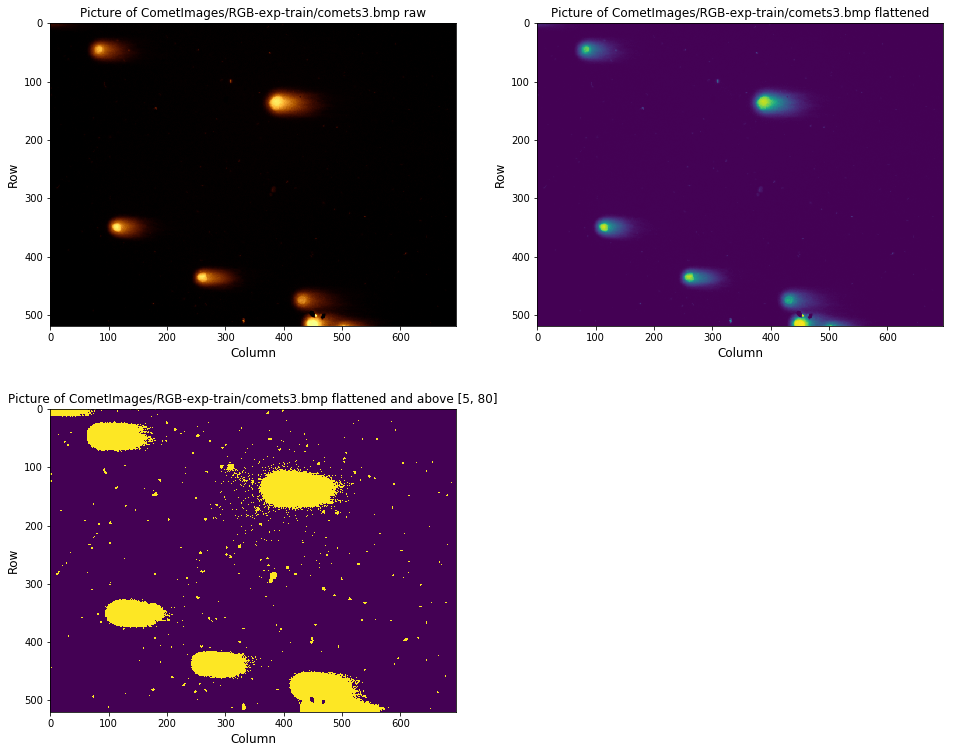

 
Date and time 2021-06-08 13:49:05.521342
Time since last check is 0:00:01.701944


In [6]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
#
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
!pwd
#
# Read in images
# Numbers ***01.bmp to ...***20.bmp
#imFile = "Images\\ControlBatch\\0001.bmp"
imFile = "CometImages/RGB-exp-train/comets3.bmp"
#
imgRaw = plt.imread(imFile)
nRows = imgRaw.shape[0] # y coordinates
nCols = imgRaw.shape[1] # x ccordinates
nDepth = imgRaw.shape[2] # ==3 for RBG, == 4 for RBGA (A is alpha, i.e. transparency) 
img = np.zeros((nRows, nCols))
#
imageFlag = 5  # 0 gives red, 1 blue, 2 green, 4 transparency, 5 intensity (sum of RBG)
#
if imageFlag < 0 or imageFlag > 5:
    print("Image flag incorrect, stop execution",sys.exit())
if imageFlag < 5:
    img[0: nRows, 0:nCols] = imgRaw[0:nRows, 0:nCols, imageFlag].astype(float) 
else:
    img[0:nRows, 0:nCols] = (imgRaw[0:nRows, 0:nCols, 0].astype(float) + imgRaw[0:nRows, 0:nCols, 1].astype(float) + 
                             imgRaw[0:nRows, 0:nCols, 2].astype(float)) # Using depth [0..2] gives intensity
#
print("Type of raw image file is",imgRaw.dtype)
print("Type of image file is",img.dtype)
print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
print("Maximum value in pixels",np.amax(img))
#
thresh = [5,80]
imgThr = np.zeros((nRows, nCols))
imgThr = img > thresh[0]
#
fig = plt.figure(figsize=(16, 13))
thisplt = fig.add_subplot(2, 2, 1)
plt.title("Picture of " + imFile + " raw")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRaw)
#
thisplt = fig.add_subplot(2, 2, 2)
plt.title("Picture of " + imFile + " flattened")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(img)
#
thisplt = fig.add_subplot(2, 2, 3)
plt.title("Picture of " + imFile + " flattened and above " + str(thresh))
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgThr)
#
#plt.savefig("imageD.png")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

In [8]:
now = datetime.datetime.now()
print("Date and time",str(now))
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
#
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
#
debug = False
if debug:
    print("Running in debug mode!")
    clusPic = np.zeros((nRows, nCols))
#
# Requirements on minimum and maximum number of pixels in wheels at the cluster and head thresholds
minClusPixels = 100
maxClusPixels = nRows*nCols/10
minHeadPixels = 100
maxHeadPixels = nRows*nCols/10
#
print(" ")
print("Cluster ID using Watershed algorithm")
print("Cluster threshold",thresh[0],"\b, head threshold",thresh[1],"\b.")
print("Min number of pixels in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
print("Min number of pixels in head",minHeadPixels,"\b, max number",maxHeadPixels,"\b.")
#
# Define grid of markers and background marker value:
nStepCols = 2 #was 3 
nStepRows = 2 # was 3
rMark, cMark = np.ogrid[0:nRows:nStepRows, 0:nCols:nStepCols]
if debug:
    print(" ")
    print("rMark.shape",rMark.shape,"cMark.shape",cMark.shape)
mStart = 1
markers = np.zeros((nRows, nCols)).astype(np.int)
markers[rMark, cMark] = rMark/nStepRows + cMark*nRows/(nStepRows*nStepCols) + mStart
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(markers, cmap = "CMRmap");
#
# Create image with cluster threshold and run watershed algorithm
clusImg = imgGrey > thresh[0]
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusImg);
colDotsClus = ndimage.watershed_ift(clusImg.astype(np.uint8), markers)
#
# Remove "isolated" markers (i.e. markers in regions where no cluster found)
colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions
mMaxClus = np.amax(colDotsClus)
#
# Positions of marker values
boolClus = colDotsClus >= mStart
nFoundClus = len(np.unique(colDotsClus[boolClus]))
rMarkerClus = np.zeros(nFoundClus)
rMarkerClus = np.unique(colDotsClus[boolClus])
#
# Select the clusters, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
# really large clusters (background regions in image).
nClus = 0
cMarkerClus = np.zeros(nFoundClus)
maxInDotClus = 0
for nR in range(0, nFoundClus):
    boolClus = colDotsClus == rMarkerClus[nR]
    nHereCl = np.sum(boolClus)
    if nHereCl < minClusPixels or nHereCl > maxClusPixels:
        continue
    maxInDotClus = max(maxInDotClus, nHereCl)
    cMarkerClus[nClus] = rMarkerClus[nR]
    nClus += 1
#
# Create image with head threshold and run watershed algorithm
headImg = imgGrey > thresh[1]
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(headImg);
colDotsHead = ndimage.watershed_ift(headImg.astype(np.uint8), markers)
#
# Remove "isolated" markers
colDotsHead[rMark, cMark] = colDotsHead[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions.
mMaxHead = np.amax(colDotsHead)
#
# Positions of marker values that are not background
boolHead = colDotsHead > mStart
nFoundHead = len(np.unique(colDotsHead[boolHead]))
rMarkerHead = np.zeros(nFoundHead)
rMarkerHead = np.unique(colDotsHead[boolHead])
#
# Select the heads, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
# really large clusters (background regions in image).
nHead = 0
cMarkerHead = np.zeros(nFoundHead)
maxInDotHead = 0
for nR in range(0, nFoundHead):
    boolHead = colDotsHead == rMarkerHead[nR]
    nHereHd = np.sum(boolHead)
    if nHereHd < minHeadPixels or nHereHd > maxHeadPixels:
        continue
    maxInDotHead = max(maxInDotHead, nHereHd) 
    cMarkerHead[nHead] = rMarkerHead[nR]
    nHead += 1
#
# Colour table for plots
nColTab = 4
colorTab = ['r', 'orange', 'b', 'c']
#
# Information on clusters
nInCluster = np.zeros(nClus).astype(int)
iClusSum = np.zeros(nClus)
#
# Information on pixels in clusters
lClus = np.sum(clusImg)
#
# Safe size of arrays would be number of pixels in image. Try to reduce size by using number of pixels in clusters
# The factor lFact can be used to expand array sizes
#lFact = 4
lFact = 20
indexCl = np.zeros(lFact*lClus)
cPixelsCl = np.zeros(lFact*lClus).astype(int)
rPixelsCl = np.zeros(lFact*lClus).astype(int)
iPixelsCl = np.zeros(lFact*lClus)
#
# Information on head
nInHead = np.zeros(nHead).astype(int)
iHeadSum = np.zeros(nHead)
#
# Information on pixels in head (lHead must be large enough...here probably larger than usually needed)
lHead = lClus
lFact = 20
indexHd = np.zeros(lFact*lHead)
cPixelsHd = np.zeros(lFact*lHead).astype(int)
rPixelsHd = np.zeros(lFact*lHead).astype(int)
iPixelsHd = np.zeros(lFact*lHead)
#
# Temporary information 
cPixelsHere = np.zeros(lClus).astype(int)
rPixelsHere = np.zeros(lClus).astype(int)
iPixelsHere = np.zeros(lClus)
thisPic = np.zeros((nRows, nCols))
#
# Find pixels in clusters, determine positions and plot 
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", clusters with threshold " + str(thresh[0]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
mSize = 0.001
#
nCol = 0
nLastCl = 0
for nC in range(0, nClus):
    #
    # Clusters
    boolClus = colDotsClus == cMarkerClus[nC]
    nHereCl = np.sum(boolClus).astype(int)
    #
    nInCluster[nC] = nHereCl
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolClus)
    thisPic.fill(0) 
    thisPic[rPixelsHere, cPixelsHere] = 1
    if debug:
        clusPic += thisPic
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iClusSum[nC] = np.sum(iPixelsHere)
    #
    indexCl[nLastCl:nLastCl + nHereCl] = nC*np.ones(nHereCl)
    cPixelsCl[nLastCl:nLastCl + nHereCl] = cPixelsHere[:]
    rPixelsCl[nLastCl:nLastCl + nHereCl] = rPixelsHere[:]
    iPixelsCl[nLastCl:nLastCl + nHereCl] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHere[0:nHereCl]) + yOffMax
    cLab = np.amax(cPixelsHere[0:nHereCl]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastCl = nLastCl + nHereCl
    #
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
# Find pixels in head, determine positions and plot
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", heads with threshold " + str(thresh[1]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMin = 15.0
yOffMin = 35.0
mSize = 0.001
#
nCol = 0
nLastHd = 0
for nH in range(0, nHead):
    boolHead = colDotsHead == cMarkerHead[nH]
    nHereHd = np.sum(boolHead).astype(int)
    #
    nInHead[nH] = nHereHd
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolHead)
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iHeadSum[nH] = np.sum(iPixelsHere)
    #
    indexHd[nLastHd:nLastHd + nHereHd] = nC*np.ones(nInHead[nH])
    cPixelsHd[nLastHd:nLastHd + nHereHd] = cPixelsHere[0:nHereHd]
    rPixelsHd[nLastHd:nLastHd + nHereHd] = rPixelsHere[0:nHereHd]
    iPixelsHd[nLastHd:nLastHd + nHereHd] = iPixelsHere[0:nHereHd]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amin(rPixelsHere) - xOffMin
    cLab = np.amin(cPixelsHere) - yOffMin
    plt.text(cLab, rLab, str(nH), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastHd = nLastHd + nHereHd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2021-06-08 13:49:25.000506
 
Cluster ID using Watershed algorithm
Cluster threshold 5 , head threshold 80 .
Min number of pixels in cluster 100 , max number 36192.0 .
Min number of pixels in head 100 , max number 36192.0 .


NameError: name 'imgGrey' is not defined